In [1]:
%%time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.naive_bayes import GaussianNB

import warnings
warnings.filterwarnings('ignore')

SEED = 42

Wall time: 36 s


In [4]:
import xgboost as xgb

## Load Database/Import Data 

In [5]:
df = pd.read_csv("diamonds.csv")

In [6]:
df.sort_values('table')

,Unnamed: 0,carat,cut,color,clarity,depth,table,price,x,y,z
11368,11369,1.04,Ideal,I,VS1,62.9,43.0,4997,6.45,6.41,4.04
35633,35634,0.29,Very Good,E,VS1,62.8,44.0,474,4.20,4.24,2.65
5979,5980,1.00,Fair,I,VS1,64.0,49.0,3951,6.43,6.39,4.10
22701,22702,0.30,Fair,E,SI1,64.5,49.0,630,4.28,4.25,2.75
25179,25180,2.00,Fair,H,SI1,61.2,50.0,13764,8.17,8.08,4.97
...,...,...,...,...,...,...,...,...,...,...,...
52861,52862,0.50,Fair,E,VS2,79.0,73.0,2579,5.21,5.18,4.09
52860,52861,0.50,Fair,E,VS2,79.0,73.0,2579,5.21,5.18,4.09
51342,51343,0.79,Fair,G,SI1,65.3,76.0,2362,5.52,5.13,3.35
50773,50774,0.81,Fair,F,SI2,68.8,79.0,2301,5.26,5.20,3.58


In [7]:
df.drop(df[['Unnamed: 0']],axis = 1, inplace = True)

In [8]:
#Drop x and z, who highly dependent on y, redundant
df.drop(df[['x']],axis = 1, inplace = True)
df.drop(df[['z']],axis = 1, inplace = True)

In [9]:
df = df[[c for c in df if c not in ['price']] + ['price']]
df.head()

,carat,cut,color,clarity,depth,table,y,price
0,0.23,Ideal,E,SI2,61.5,55.0,3.98,326
1,0.21,Premium,E,SI1,59.8,61.0,3.84,326
2,0.23,Good,E,VS1,56.9,65.0,4.07,327
3,0.29,Premium,I,VS2,62.4,58.0,4.23,334
4,0.31,Good,J,SI2,63.3,58.0,4.35,335


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53940 entries, 0 to 53939
Data columns (total 8 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   carat    53940 non-null  float64
 1   cut      53940 non-null  object 
 2   color    53940 non-null  object 
 3   clarity  53940 non-null  object 
 4   depth    53940 non-null  float64
 5   table    53940 non-null  float64
 6   y        53940 non-null  float64
 7   price    53940 non-null  int64  
dtypes: float64(4), int64(1), object(3)
memory usage: 3.3+ MB


In [11]:
#drop the rows with value 0 in x,y,z
#df = df.drop(df[df['x']==0].index)
df = df.drop(df[df['y']==0].index)
#df = df.drop(df[df['z']==0].index)

In [12]:
df.shape

(53933, 8)

In [13]:
df.isna().any().any()
# df.isna().sum()

False

In [14]:
#remove outliers
df = df[(df["table"]<75) & (df["table"] > 45)]
#remove outliers
df = df[(df["y"]<30)] 
#remove outliers
df = df[(df["depth"]<75)&(df["depth"]>45)] 


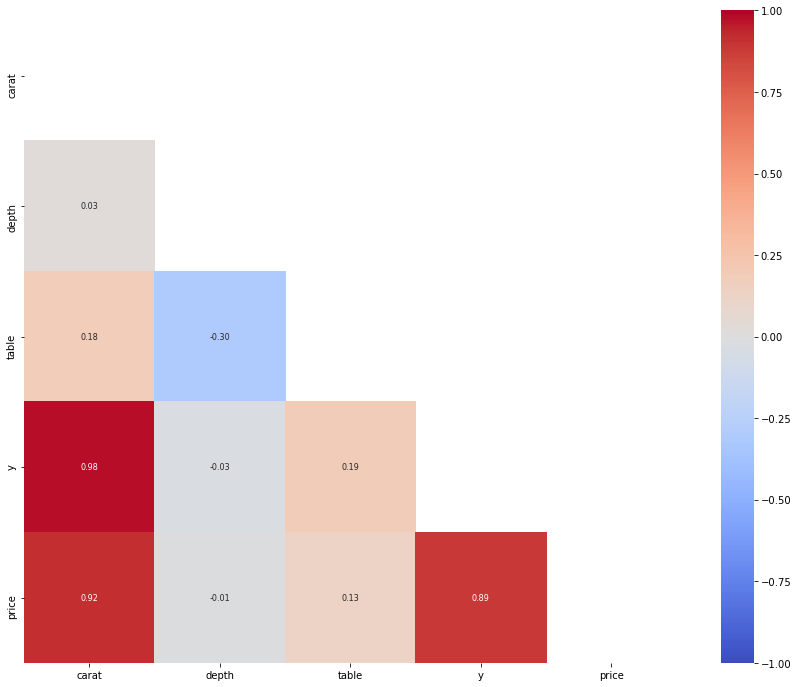

In [12]:
# Generate a mask for the upper triangle
matrix = np.triu(df.corr())

# Set up the matplotlib figure to control size of heatmap
fig, ax = plt.subplots(figsize=(16,12))

# Plot the heatmap
_ = sns.heatmap(df.corr(), mask=matrix, annot=True, annot_kws={"size": 8}, square=True, 
                cmap='coolwarm' , vmin=-1, vmax=1, fmt='.2f') 

Wall time: 2.74 s


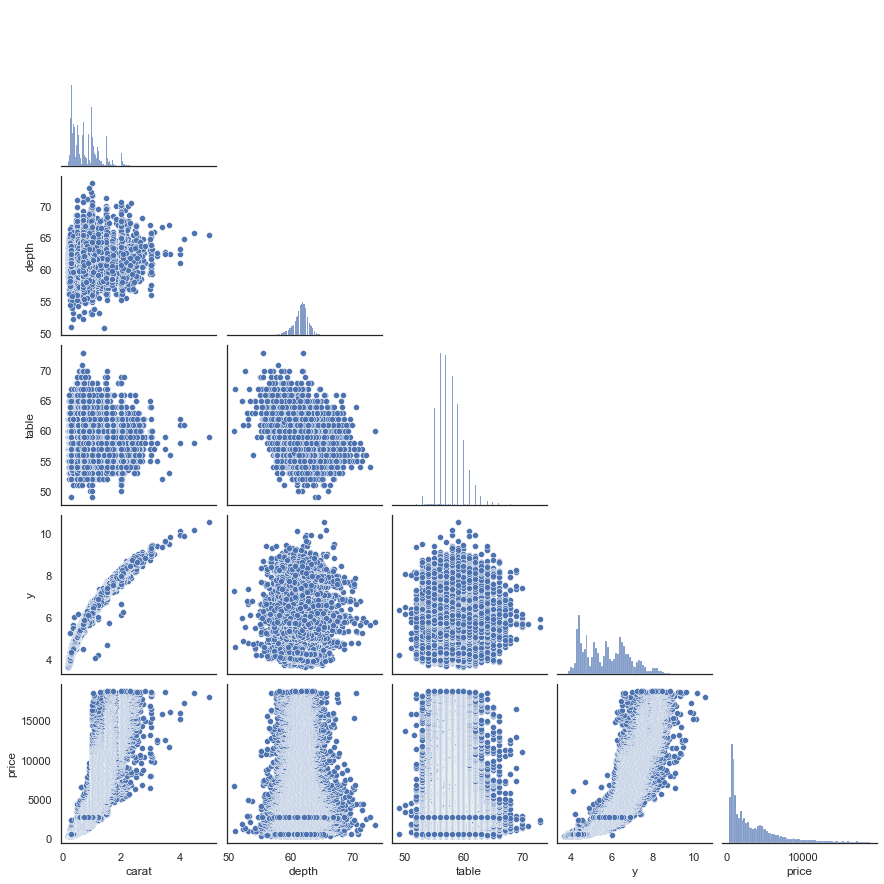

In [32]:
%%time
_ = sns.pairplot(df, corner=True, palette = 'inferno')
# correlation matrix heatmap visualization
sns.set(style="white")

In [15]:
# Encode variables with more than 2 Classes
df = pd.get_dummies(df, columns= [i for i in df.columns if df[i].dtypes=='object'],drop_first=True)

In [16]:
df = df[[c for c in df if c not in ['price']] + ['price']]
df.head()

,carat,depth,table,y,cut_Good,cut_Ideal,cut_Premium,cut_Very Good,color_E,color_F,...,color_I,color_J,clarity_IF,clarity_SI1,clarity_SI2,clarity_VS1,clarity_VS2,clarity_VVS1,clarity_VVS2,price
0,0.23,61.5,55.0,3.98,0,1,0,0,1,0,...,0,0,0,0,1,0,0,0,0,326
1,0.21,59.8,61.0,3.84,0,0,1,0,1,0,...,0,0,0,1,0,0,0,0,0,326
2,0.23,56.9,65.0,4.07,1,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,327
3,0.29,62.4,58.0,4.23,0,0,1,0,0,0,...,1,0,0,0,0,0,1,0,0,334
4,0.31,63.3,58.0,4.35,1,0,0,0,0,0,...,0,1,0,0,1,0,0,0,0,335


## Data Preprocessing/Feature Engineering

## Model Selection

### Split Data (Features/Target, Train/Validation/Testing)

In [17]:
X = df.drop(['price'], axis=1)
y = df['price']

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=SEED)

#### Feature Scaling (Normalization/Standardization)

In [19]:
scaler = StandardScaler()

# Fit only to the training data
scaler.fit(X_train)

StandardScaler(copy=True, with_mean=True, with_std=True)

# Now apply the transformations to the data:
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [40]:
X_test

array([[-0.88083756, -3.9070016 ,  1.60696614, ...,  1.843239  ,
        -0.27221974, -0.32366082],
       [ 1.47596744,  0.59461324, -1.10642673, ..., -0.54252324,
        -0.27221974, -0.32366082],
       [ 1.91786838,  0.24292458,  0.25026971, ..., -0.54252324,
        -0.27221974, -0.32366082],
       ...,
       [ 0.02400722, -1.79686964, -0.20196244, ..., -0.54252324,
        -0.27221974, -0.32366082],
       [-1.04918078,  0.10224912,  0.70250185, ..., -0.54252324,
        -0.27221974,  3.08965412],
       [-0.01807859, -0.24943954,  0.70250185, ..., -0.54252324,
        -0.27221974, -0.32366082]])

### Train a Model
### (start with Logistic Regression for Classification problems, Linear Regression for Regression problems)

In [20]:
results = []
names = []
scoring='r2'

In [108]:
%%time
lr_baseline = LinearRegression()
scores = cross_val_score(lr_baseline, X_train,y_train, scoring=scoring, cv=5,n_jobs=-1)
baseline_mean_score = scores.mean()
print("Baseline Model's score: {:.2f} (avg) {:.2f} (std)".format(scores.mean(), scores.std()))
results.append(scores)
names.append('LR')

Baseline Model's score: 0.92 (avg) 0.00 (std)
Wall time: 26.3 s


In [109]:
results

[array([0.91357604, 0.92564848, 0.91872992, 0.9172607 , 0.91533027])]

In [110]:
names

['LR']

### Evaluate Multiple Models and Select Best Model

In [111]:
%%time
KNNReg = KNeighborsRegressor()
scores = cross_val_score(KNNReg, X_train,  y_train, cv=5,  scoring=scoring)
msg = ("KNN Mean score: {:.2f} (avg) {:.2f} (std)".format(scores.mean(), scores.std()))
print(msg)
results.append(scores)
names.append('KNN')

KNN Mean score: 0.94 (avg) 0.00 (std)
Wall time: 33.6 s


In [112]:
results

[array([0.91357604, 0.92564848, 0.91872992, 0.9172607 , 0.91533027]),
 array([0.93629693, 0.9342846 , 0.93399841, 0.93909517, 0.93632777])]

In [113]:
names

['LR', 'KNN']

In [114]:
%%time
MLPReg = MLPRegressor()
scores = cross_val_score(MLPReg, X_train,  y_train, cv=5,  scoring=scoring)
msg = ("MLPReg Mean score: {:.2f} (avg) {:.2f} (std)".format(scores.mean(), scores.std()))
print(msg)
results.append(scores)
names.append('MLP')

MLPReg Mean score: 0.96 (avg) 0.00 (std)
Wall time: 2min 45s


In [115]:
results

[array([0.91357604, 0.92564848, 0.91872992, 0.9172607 , 0.91533027]),
 array([0.93629693, 0.9342846 , 0.93399841, 0.93909517, 0.93632777]),
 array([0.96283887, 0.9683675 , 0.96489754, 0.96430647, 0.96165621])]

In [116]:
names

['LR', 'KNN', 'MLP']

In [117]:
%%time
DT = DecisionTreeRegressor()
scores = cross_val_score(DT, X_train,  y_train, cv=5,  scoring=scoring)
msg = ("DT Mean score: {:.2f} (avg) {:.2f} (std)".format(scores.mean(), scores.std()))
print(msg)
results.append(scores)
names.append('DT')

DT Mean score: 0.95 (avg) 0.00 (std)
Wall time: 1.02 s


In [118]:
results

[array([0.91357604, 0.92564848, 0.91872992, 0.9172607 , 0.91533027]),
 array([0.93629693, 0.9342846 , 0.93399841, 0.93909517, 0.93632777]),
 array([0.96283887, 0.9683675 , 0.96489754, 0.96430647, 0.96165621]),
 array([0.95331602, 0.94744034, 0.95415169])]

In [119]:
names

['LR', 'KNN', 'MLP', 'DT']

In [120]:
%%time
RF = RandomForestRegressor()
scores = cross_val_score(RF, X_train,  y_train, cv=5,  scoring=scoring)
msg = ("RF Mean score: {:.2f} (avg) {:.2f} (std)".format(scores.mean(), scores.std()))
print(msg)
results.append(scores)
names.append('RF')

RF Mean score: 0.97 (avg) 0.00 (std)
Wall time: 37.4 s


In [121]:
results

[array([0.91357604, 0.92564848, 0.91872992, 0.9172607 , 0.91533027]),
 array([0.93629693, 0.9342846 , 0.93399841, 0.93909517, 0.93632777]),
 array([0.96283887, 0.9683675 , 0.96489754, 0.96430647, 0.96165621]),
 array([0.95331602, 0.94744034, 0.95415169]),
 array([0.97125926, 0.97194189, 0.9721208 ])]

In [122]:
names

['LR', 'KNN', 'MLP', 'DT', 'RF']

In [114]:
%%time
xg_reg = xgb.XGBRegressor()
scores = cross_val_score(xg_reg, X_train,  y_train, cv=5,  scoring=scoring)
msg = ("xg_reg Mean score: {:.2f} (avg) {:.2f} (std)".format(scores.mean(), scores.std()))
print(msg)
results.append(scores)
names.append('xg_reg')

xg_reg Mean score: 0.98 (avg) 0.00 (std)
Wall time: 6.47 s


In [125]:
results

[array([0.91357604, 0.92564848, 0.91872992, 0.9172607 , 0.91533027]),
 array([0.93629693, 0.9342846 , 0.93399841, 0.93909517, 0.93632777]),
 array([0.96283887, 0.9683675 , 0.96489754, 0.96430647, 0.96165621]),
 array([0.95331602, 0.94744034, 0.95415169]),
 array([0.97125926, 0.97194189, 0.9721208 ]),
 array([0.97646056, 0.97666684, 0.97654977])]

In [126]:
names

['LR', 'KNN', 'MLP', 'DT', 'RF', 'xg_reg']

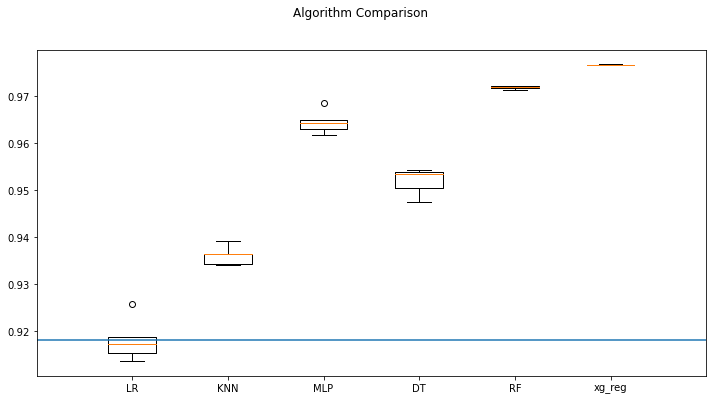

In [129]:
fig = plt.figure(figsize=(12,6))
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.plot([-2,19], [baseline_mean_score, baseline_mean_score])
plt.xlim(0, 7)
plt.show()

### Hyperparameter Fine-tuning for final selected model # Random Forest

### Evaluate the fine-tuned Model (whether it will generalize well with unseen data - testing dataset)

In [21]:
%%time
xgbr = xgb.XGBRegressor(objective='reg:squarederror')
xgbr.fit(X_train, y_train)
y_pred = xgbr.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
print("RMSE: %.2f" % (mse**(1/2.0)))
mae = mean_absolute_error(y_test, y_pred)
print("Mean Absolute Error: %.2f" % (mae))
r2 = r2_score(y_test, y_pred)
print("r2 score: %.2f" % (r2))


RMSE: 580.93
Mean Absolute Error: 300.22
r2 score: 0.98
Wall time: 2.5 s


In [22]:
xgbr

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [23]:
%%time
dmatrix = xgb.DMatrix(data=X_train, label=y_train)
params={'objective':'reg:squarederror'}
cv_results = xgb.cv(dtrain=dmatrix, params=params, nfold=10, metrics={'rmse'}, as_pandas=True, seed=20)
print('RMSE: %.2f' % cv_results['test-rmse-mean'].min())


RMSE: 842.68
Wall time: 2.77 s


In [23]:
%%time
dmatrix = xgb.DMatrix(data=X_train, label=y_train)
params={ 'objective':'reg:squarederror',
         'max_depth': 6, 
         'colsample_bylevel':0.5,
         'learning_rate':0.01,
         'random_state':20}
cv_results = xgb.cv(dtrain=dmatrix, params=params, nfold=10, metrics={'rmse'}, as_pandas=True, seed=20, num_boost_round=1000)
print('RMSE: %.2f' % cv_results['test-rmse-mean'].min())



RMSE: 664.34
Wall time: 2min 43s


In [65]:
# %%time
# params = { 'max_depth': [3,6,10],
#            'learning_rate': [0.01, 0.05, 0.1],
#            'n_estimators': [100, 500, 1000],
#            'colsample_bytree': [0.3, 0.7]}

# xgbr = xgb.XGBRegressor(seed = 20)
# gs_clf = GridSearchCV(estimator=xgbr, 
#                    param_grid=params,
#                    scoring='neg_mean_squared_error', 
#                    verbose=1)

# gs_clf.fit(X_train, y_train)
# final_clf = gs_clf.best_estimator_

Fitting 5 folds for each of 54 candidates, totalling 270 fits
Wall time: 40min 47s


In [74]:
# print("Best parameters:", gs_clf.best_params_)
# print("Lowest RMSE: ", (-gs_clf.best_score_)**(1/2))

Best parameters: {'colsample_bytree': 0.7, 'learning_rate': 0.05, 'max_depth': 6, 'n_estimators': 1000}
Lowest RMSE:  572.8862012883283


In [24]:
%%time
params = { 'max_depth': [6],
           'learning_rate': [0.05],
           'n_estimators': [1000],
           'colsample_bytree': [0.7]}

xgbr = xgb.XGBRegressor(seed = 20)
gs_clf = GridSearchCV(estimator=xgbr, 
                   param_grid=params,
                   scoring='neg_mean_squared_error', 
                   verbose=1)

gs_clf.fit(X_train, y_train)
final_clf = gs_clf.best_estimator_

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Wall time: 1min 41s


In [25]:
y_pred = final_clf.predict(X_test)

r2score = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print('Final Model (XGBOOST) Metrics -')
print('\tR2 Score:', r2score)
print('\tMean Absolute Error:', mae)
print('\tMean Square Error:', mse)

Final Model (XGBOOST) Metrics -
	R2 Score: 0.9800541054361103
	Mean Absolute Error: 285.4353701311332
	Mean Square Error: 311106.3137782817


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

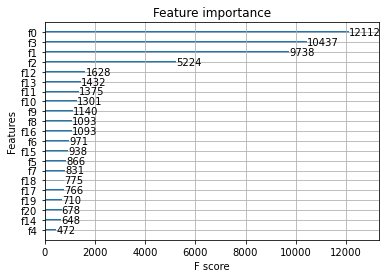

In [120]:
from xgboost import plot_importance
# Plot feature importance
plot_importance(final_clf)



In [122]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53920 entries, 0 to 53939
Data columns (total 22 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   carat          53920 non-null  float64
 1   depth          53920 non-null  float64
 2   table          53920 non-null  float64
 3   y              53920 non-null  float64
 4   cut_Good       53920 non-null  uint8  
 5   cut_Ideal      53920 non-null  uint8  
 6   cut_Premium    53920 non-null  uint8  
 7   cut_Very Good  53920 non-null  uint8  
 8   color_E        53920 non-null  uint8  
 9   color_F        53920 non-null  uint8  
 10  color_G        53920 non-null  uint8  
 11  color_H        53920 non-null  uint8  
 12  color_I        53920 non-null  uint8  
 13  color_J        53920 non-null  uint8  
 14  clarity_IF     53920 non-null  uint8  
 15  clarity_SI1    53920 non-null  uint8  
 16  clarity_SI2    53920 non-null  uint8  
 17  clarity_VS1    53920 non-null  uint8  
 18  clarit

In [52]:
from xgboost import plot_tree
from graphviz import Digraph

<Figure size 2160x2160 with 0 Axes>

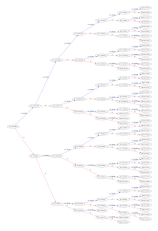

In [72]:
#, num_trees = 1
plt.figure(figsize = (30,30))
plot_tree(final_clf, rankdir = 'LR')
plt.show()

In [84]:
# #fig, ax = plt.subplots(figsize=(30, 30))
# fig = plt.figure(figsize = (30,30))
# xgb.to_graphviz(final_clf, num_trees=0, rankdir='LR')
# fig.show()
# #fig.savefig("temp.jpg")

<Figure size 2160x2160 with 0 Axes>

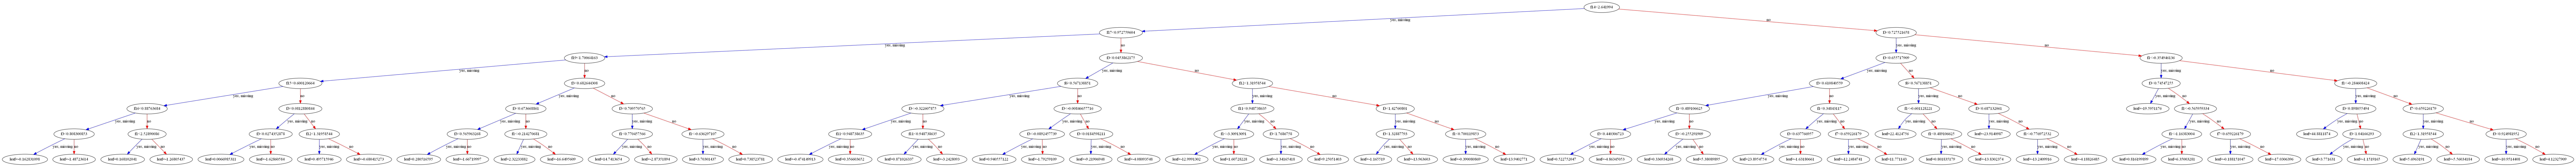

In [95]:
xgb.plot_tree(final_clf, num_trees=999)
fig = plt.gcf()
fig.set_size_inches(300, 50)
fig.savefig('tree999.png')


In [69]:
final_clf

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.05, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=1000, n_jobs=4, num_parallel_tree=1, random_state=20,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=20,
             subsample=1, tree_method='exact', validate_parameters=1,
             verbosity=None)

## Post-mortem Analysis

In [47]:
own_pred = final_clf.predict(X_test)
for n in range(100):
    print("target value ",str(own_pred[n]), "VS", str(y_test.iloc[n]),"% as", (y_test.iloc[n]) / (own_pred[n])*100)
    n += 1

target value  820.8751258503399 VS 873 % as 106.34991517079581
target value  10716.770462585033 VS 9265 % as 86.45328396597154
target value  10766.64118367347 VS 11737 % as 109.0126419165708
target value  1060.930891156462 VS 1064 % as 100.28928452070922
target value  801.575273809524 VS 906 % as 113.02743854537735
target value  3390.4983503401354 VS 3527 % as 104.02600548813629
target value  3216.6167687074835 VS 2638 % as 82.01163488493576
target value  1169.0908333333336 VS 893 % as 76.38414180819994
target value  2314.892602040817 VS 2247 % as 97.06713814796579
target value  4639.336801020406 VS 4547 % as 98.00969826118042
target value  1031.2018197278912 VS 926 % as 89.79813478649102
target value  908.8116887755103 VS 795 % as 87.47686785049444
target value  612.6034047619048 VS 526 % as 85.86305526728762
target value  5583.9255544217685 VS 5637 % as 100.95048626742889
target value  1643.3916632653054 VS 1336 % as 81.29528887504884
target value  635.721380952381 VS 625 % as 98.313

In [26]:
import pickle

In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53920 entries, 0 to 53939
Data columns (total 22 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   carat          53920 non-null  float64
 1   depth          53920 non-null  float64
 2   table          53920 non-null  float64
 3   y              53920 non-null  float64
 4   cut_Good       53920 non-null  uint8  
 5   cut_Ideal      53920 non-null  uint8  
 6   cut_Premium    53920 non-null  uint8  
 7   cut_Very Good  53920 non-null  uint8  
 8   color_E        53920 non-null  uint8  
 9   color_F        53920 non-null  uint8  
 10  color_G        53920 non-null  uint8  
 11  color_H        53920 non-null  uint8  
 12  color_I        53920 non-null  uint8  
 13  color_J        53920 non-null  uint8  
 14  clarity_IF     53920 non-null  uint8  
 15  clarity_SI1    53920 non-null  uint8  
 16  clarity_SI2    53920 non-null  uint8  
 17  clarity_VS1    53920 non-null  uint8  
 18  clarit

In [67]:
X.columns

Index(['carat', 'depth', 'table', 'y', 'cut_Good', 'cut_Ideal', 'cut_Premium',
       'cut_Very Good', 'color_E', 'color_F', 'color_G', 'color_H', 'color_I',
       'color_J', 'clarity_IF', 'clarity_SI1', 'clarity_SI2', 'clarity_VS1',
       'clarity_VS2', 'clarity_VVS1', 'clarity_VVS2'],
      dtype='object')

In [114]:
Usr_Input = []
carat = input('Carat: ')
Usr_Input.append(float(carat))
depth = input('depth: ')
Usr_Input.append(float(depth))
table = input('table: ')
Usr_Input.append(float(table))
y = input('y: ')
Usr_Input.append(float(y))
cut = input('cut:Good/Ideal/Premium/Very Good: ')
if cut == 'Good':
    Usr_Input.append(1)
    Usr_Input.append(0)
    Usr_Input.append(0)
    Usr_Input.append(0)
elif cut == 'Ideal':
    Usr_Input.append(0)
    Usr_Input.append(1)
    Usr_Input.append(0)
    Usr_Input.append(0)
elif cut == 'Premium':
    Usr_Input.append(0)
    Usr_Input.append(0)
    Usr_Input.append(1)
    Usr_Input.append(0)
elif cut == 'Very Good':
    Usr_Input.append(0)
    Usr_Input.append(0)
    Usr_Input.append(0)
    Usr_Input.append(1)
else:
    Usr_Input.append(1)
    Usr_Input.append(0)
    Usr_Input.append(0)
    Usr_Input.append(0)


Color = input('Color:E/F/G/H/I/J : ')
if Color == 'E':
    Usr_Input.append(1)
    Usr_Input.append(0)
    Usr_Input.append(0)
    Usr_Input.append(0)
    Usr_Input.append(0)
    Usr_Input.append(0)
elif Color == 'F':
    Usr_Input.append(0)
    Usr_Input.append(1)
    Usr_Input.append(0)
    Usr_Input.append(0)
    Usr_Input.append(0)
    Usr_Input.append(0)
elif Color == 'G':
    Usr_Input.append(0)
    Usr_Input.append(0)
    Usr_Input.append(1)
    Usr_Input.append(0)
    Usr_Input.append(0)
    Usr_Input.append(0)
elif Color == 'H':
    Usr_Input.append(0)
    Usr_Input.append(0)
    Usr_Input.append(0)
    Usr_Input.append(1)
    Usr_Input.append(0)
    Usr_Input.append(0)
elif Color == 'I':
    Usr_Input.append(0)
    Usr_Input.append(0)
    Usr_Input.append(0)
    Usr_Input.append(0)
    Usr_Input.append(1)
    Usr_Input.append(0)
elif Color == 'J':
    Usr_Input.append(0)
    Usr_Input.append(0)
    Usr_Input.append(0)
    Usr_Input.append(0)
    Usr_Input.append(0)
    Usr_Input.append(1)
else:
    Usr_Input.append(1)
    Usr_Input.append(0)
    Usr_Input.append(0)
    Usr_Input.append(0)
    Usr_Input.append(0)
    Usr_Input.append(0)
        
Clarity = input('Clarity:IF/SI1/SI2/VS1/VS2/VVS1/VVS2 : ')
if Clarity == 'IF':
    Usr_Input.append(1)
    Usr_Input.append(0)
    Usr_Input.append(0)
    Usr_Input.append(0)
    Usr_Input.append(0)
    Usr_Input.append(0)
    Usr_Input.append(0)
elif Color == 'SI1':
    Usr_Input.append(0)
    Usr_Input.append(1)
    Usr_Input.append(0)
    Usr_Input.append(0)
    Usr_Input.append(0)
    Usr_Input.append(0)
    Usr_Input.append(0)    
elif Color == 'SI2':
    Usr_Input.append(0)
    Usr_Input.append(0)
    Usr_Input.append(1)
    Usr_Input.append(0)
    Usr_Input.append(0)
    Usr_Input.append(0)
    Usr_Input.append(0)
elif Color == 'VS1':
    Usr_Input.append(0)
    Usr_Input.append(0)
    Usr_Input.append(0)
    Usr_Input.append(1)
    Usr_Input.append(0)
    Usr_Input.append(0)
    Usr_Input.append(0)
elif Color == 'VS2':
    Usr_Input.append(0)
    Usr_Input.append(0)
    Usr_Input.append(0)
    Usr_Input.append(0)
    Usr_Input.append(1)
    Usr_Input.append(0)
    Usr_Input.append(0)
elif Color == 'VVS1':
    Usr_Input.append(0)
    Usr_Input.append(0)
    Usr_Input.append(0)
    Usr_Input.append(0)
    Usr_Input.append(0)
    Usr_Input.append(1)
    Usr_Input.append(0)
elif Color == 'VVS2':
    Usr_Input.append(0)
    Usr_Input.append(0)
    Usr_Input.append(0)
    Usr_Input.append(0)
    Usr_Input.append(0)
    Usr_Input.append(0)
    Usr_Input.append(1)
else:
    Usr_Input.append(1)
    Usr_Input.append(0)
    Usr_Input.append(0)
    Usr_Input.append(0)
    Usr_Input.append(0)
    Usr_Input.append(0)
    Usr_Input.append(0)

Carat: 1
depth: 68
table: 68
y: 40
cut:Good/Ideal/Premium/Very Good: Ideal
Color:E/F/G/H/I/J : E
Clarity:IF/SI1/SI2/VS1/VS2/VVS1/VVS2 : IF


In [121]:
result = loaded_model.predict(scaler_result)
print(result)


[12572.2295]


In [120]:
print(Usr_Input)

[ 1. 68. 68. 40.  0.  1.  0.  0.  1.  0.  0.  0.  0.  0.  1.  0.  0.  0.
  0.  0.  0.]


In [117]:
Usr_Input = np.array(Usr_Input)

In [118]:
#pass the value into scaler and dump into a file.
filename = 'diamond_Price_Prediction_scaler.sav'
pickle.dump(scaler, open(filename, 'wb'))

#load the file and save the result as variable
loaded_scaler = pickle.load(open(filename, 'rb'))
scaler_result = loaded_scaler.transform([Usr_Input])
print(scaler_result)


[[ 0.42382235  4.39285076  4.77259116 30.75494371 -0.31666994  1.22296201
  -0.58248999 -0.53851299  2.13072689 -0.46266927 -0.51231612 -0.42970432
  -0.33610345 -0.23453986  5.46690684 -0.56613178 -0.44948661 -0.42232507
  -0.54252324 -0.27221974 -0.32366082]]


In [119]:
#dump the 
filename = 'diamond_Price_Prediction_model.sav'
pickle.dump(final_clf, open(filename, 'wb'))
# load the model from disk
loaded_model = pickle.load(open(filename, 'rb'))
# some time later...
 

In [33]:
n = 101
X_test[n]

array([-0.2074647 ,  0.17258685, -1.10642673, -0.05783164, -0.31666994,
        1.22296201, -0.58248999, -0.53851299, -0.46932341,  2.16137113,
       -0.51231612, -0.42970432, -0.33610345, -0.23453986, -0.18291879,
       -0.56613178, -0.44948661, -0.42232507, -0.54252324, -0.27221974,
        3.08965412])

In [34]:
loaded_model = pickle.load(open(filename, 'rb'))
user_input = X_test[[n]]
user_pred = loaded_model.predict(user_input)
print(user_pred)


[3361.7212]


In [89]:
type(X_test[[n]])

numpy.ndarray

In [35]:
y_test.iloc[n]

3191

In [86]:
type(Usr_Input)

list

['1' '40' '40' '2' '1' '0' '0' '0' '0' '1' '0' '0' '0' '0' '1' '0' '0' '0'
 '0' '0' '0']


In [33]:
# Creating the feature importances dataframe
feature_importance = np.array(rf.feature_importances_)
feature_names = np.array(X.columns)

feat_imp = pd.DataFrame({'feature_names':feature_names,'feature_importance':feature_importance})
feat_imp_sorted = feat_imp.sort_values('feature_importance', ascending=False)

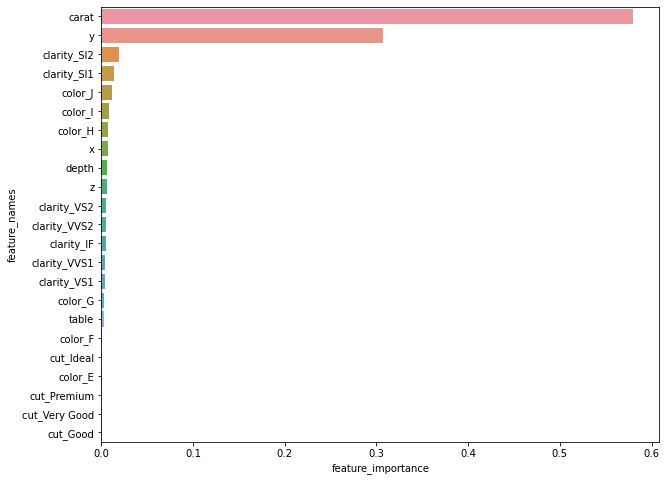

In [34]:
plt.figure(figsize=(10,8))
_ = sns.barplot(x=feat_imp_sorted['feature_importance'], y=feat_imp_sorted['feature_names'])

In [54]:
import numpy as np
from sklearn import metrics
y = np.array([1, 1, 2, 2])
scores = np.array([0.1, 0.4, 0.35, 0.8])
fpr, tpr, thresholds = metrics.roc_curve(y, scores, pos_label=2)
tpr

array([0. , 0.5, 0.5, 1. , 1. ])

In [53]:
fpr

array([0. , 0. , 0.5, 0.5, 1. ])

In [55]:
thresholds

array([1.8 , 0.8 , 0.4 , 0.35, 0.1 ])